In [1174]:
import random
import matplotlib.pyplot as plt
import math
import sys
import warnings
import numpy as np

Уравнение

$$\frac{\partial u}{\partial t} = a \frac{\partial^2 u}{\partial x^2} + b\frac{\partial u}{\partial x}, a > 0, b > 0$$

Граничные условия

$$u_x(0,t)-u(0,t) = -e^{-at}(cos(bt) + sin(bt)),\\
u_x(\pi,t)-u(\pi,t) = e^{-at}(cos(bt) + sin(bt))$$

Начальное условие

$$u(x,0) = cos(x)$$

Аналитическое решение

$$U(x,t) = e^{(-at)}cos(x+bt)$$

In [1175]:
def phi_0(t, a = 1., b = 1.):
    return -np.exp(-a * t) * (np.cos(b * t) + np.sin(b * t))

def phi_l(t, a = 1., b = 1.):
    return np.exp(-a * t) * (np.cos(b * t) + np.sin(b * t))

def u_0(x):
    return np.cos(x)

def U(x, t, a = 1., b = 1.):
    return np.exp(-a * t) * np.cos(x + b * t)


In [1176]:
class Grid:
    def __init__(self, a = 1., b = 1., alpha = 1, beta = -1, gamma = 1, delta = -1,
                 phi_0 = phi_0, phi_l = phi_l, u0 = u_0, theta = 0.5, l0 = 0, l1 = np.pi, T=2, aprx_cls=None):
        self.phi_0 = lambda t: phi_0(t,a,b)
        self.phi_l = lambda t: phi_l(t,a,b)
        self.a = a
        self.b = b
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.T = T
        self.h = None
        self.tau = None
        self.u0 = u0
        self.l0 = l0
        self.l1 = l1
        self.theta = theta
        self.approx = None
        if aprx_cls is not None:
            self._init_approx(aprx_cls)
        self.sigma = None
        self.xi = None
    
    def _init_approx(self, a_cls):
        self.approx = a_cls(self.phi_0, self.phi_l, self.alpha, self.beta, self.gamma, self.delta)

    def set_approx(self, aprx_cls):
        self._init_approx(self, aprx_cls)

    def set_l0l1(self, l0, l1):
        self.l0 = l0
        self.l1 = l1

    def set_T(self, T):
        self.T = T

    def set_h(self, N):
        self.h = (self.l1 - self.l0) / N

    def set_tau(self, K):
        self.tau = self.T / K

    def set_sigma(self):
        self.sigma = self.a * self.tau / (self.h * self.h)

    def set_xi(self):
        self.xi = self.b * self.tau / (2. * self.h)

    @staticmethod
    def nparange(start, end, step = 1):
        now = start
        e = 1e-7
        while now - e <= end:
            yield now
            now += step
        
    def set_line(self, t, x, prev_line):
        pass
    
    def __call__(self, N=50, K=100):
        N, K = N-1, K-1
        self.set_tau(K)
        self.set_h(N)
        self.set_sigma()
        self.set_xi()

        X = list(self.nparange(self.l0, self.l1, self.h))

        Y = []
        Y.append(0.0)

        ans = []
        prev_line = list(map(self.u0, X))
        ans.append(list(prev_line))
        
        
        for t in self.nparange(self.tau, self.T, self.tau):
            ans.append(self.set_line(t, X, prev_line))
            Y.append(t)
            prev_line = ans[-1]
        return X, Y, ans


Аппроксимируем вторую производную по значениям нижнего временного слоя $t^k$:

$$\frac{u_j^{k+1}-u_j^k}{\tau} = a \frac{u_{j+1}^{k}-2u_j^{k} + u_{j-1}^{k}}{h^2} + b \frac{u_{j+1}^{k} - u_{j-1}^{k}}{2h}, j = 1,..,N-1$$

Получим явную схему конечно-разностного метода.

Обозначим $\sigma = \frac{a \tau}{h^2}, \xi = \frac{b \tau}{2h}$ тогда:

$$u_j^{k+1} = (\sigma + \xi)u_{j-1}^k + (1 - 2\sigma)u_j^k + (\sigma + \xi)u_{j+1}^k$$

Граничные значения определяются граничными условиями. 

In [1177]:
class Explicit(Grid):
    def set_sigma(self):
        self.sigma = self.a * self.tau / (self.h * self.h)
        if self.sigma > 0.5:
            warnings.warn("Sigma > 0.5")
    def set_xi(self):
        self.xi = self.b * self.tau / (2 * self.h)

    def set_line(self, t, x, prev_line):
        new_line = [None for _ in prev_line]
        for i in range(1, len(x) - 1):
            new_line[i] = ((self.sigma + self.xi) * prev_line[i + 1] +
                            (1. - 2. * self.sigma) * prev_line[i] +
                            (self.sigma - self.xi) * prev_line[i - 1])
        new_line[0] = self.approx.explicit_0(t, self.h, self.sigma, self.xi,
                                                prev_line, new_line, t - self.tau)
        new_line[-1] = self.approx.explicit_l(t, self.h, self.sigma, self.xi,
                                                prev_line, new_line, t - self.tau)
        return new_line

Поскольку решение в зависимости от времени лежит между значениями явно и неявной схемы, введем явно-неявную схему.\\

Аппроксимируем вторую производную по значениям верхнего временного слоя $t^{k+1}$

$$\frac{u_j^{k+1}-u_j^k}{\tau} =\theta \left(a \frac{u_{j+1}^{k+1}-2u_j^{k+1} + u_{j-1}^{k+1}}{h^2} + b \frac{u_{j+1}^{k+1} - u_{j-1}^{k+1}}{2h} \right) +  (1 -\theta) \left(a \frac{u_{j+1}^{k}-2u_j^{k} + u_{j-1}^{k}}{h^2} + b \frac{u_{j+1}^{k} - u_{j-1}^{k}}{2h} \right), j = 1,..,N-1$$

$\theta = 1/2$ - схема Кранка-Николсона.

$\theta = 1$ - неявная схема.

Приведем подобные слгаемые и сделаем замену: $\sigma = \frac{a \tau}{h^2}, \xi = \frac{b \tau}{2h}$. Получим СЛАУ с трехдиагональной матрицей.

$$a_ju_{j-1}^{k+1} + b_ju_j^{k+1} + c_ju_{j+1}^{k+1} = d_j, j = 1,..,N-1$$
$$a_j = \theta(\sigma + \xi), b_j = (1 - 2\theta \sigma), c_j = \theta(\sigma - \xi), d_j = -(u_j^k + (1-\theta)((\sigma + \xi)u_{j-1}^k - 2\sigma u_j^k + (\sigma - \xi)u_{j+1}^k)$$

In [1178]:
class Implicit(Grid):
    def set_theta(self, theta):
        self.theta = theta
    
    @staticmethod
    def Tridiagonal_Algorithm(A, b):
        P = [-item[2] for item in A]
        Q = [item for item in b]
    
        P[0] /= A[0][1]
        Q[0] /= A[0][1]
    
        for i in range(1, len(b)):
            z = (A[i][1] + A[i][0] * P[i-1])
            P[i] /= z
            Q[i] -= A[i][0] * Q[i-1]
            Q[i] /= z
    
        x = [item for item in Q]

        for i in range(len(x) - 2, -1, -1):
            x[i] += P[i] * x[i + 1]

        return x
    
    def set_line(self, t, x, prev_line):
        a = (self.sigma + self.xi)
        b = -(2. * self.sigma + 1.)
        c = (self.sigma - self.xi)
        A = [(a, b, c) for _ in range(1, len(x) - 1)]
        b = [-prev_line[j] for j in range (1, len(x) - 1)]

        borders = self.approx.exp_imp_0(t, self.h, self.sigma, self.xi, prev_line, self.theta, t - self.tau)
        A.insert(0, borders[:-1])
        b.insert(0, borders[-1])

        borders = self.approx.exp_imp_l(t, self.h, self.sigma, self.xi, prev_line, self.theta, t - self.tau)
        A.append(borders[:-1])
        b.append(borders[-1])

        return self.Tridiagonal_Algorithm(A, b)


In [1179]:
class Explicit_Implicit(Grid):
    def set_theta(self, theta):
        self.theta = theta
    
    @staticmethod
    def Tridiagonal_Algorithm(A, b):
        P = [-item[2] for item in A]
        Q = [item for item in b]
    
        P[0] /= A[0][1]
        Q[0] /= A[0][1]
    
        for i in range(1, len(b)):
            z = (A[i][1] + A[i][0] * P[i-1])
            P[i] /= z
            Q[i] -= A[i][0] * Q[i-1]
            Q[i] /= z
    
        x = [item for item in Q]

        for i in range(len(x) - 2, -1, -1):
            x[i] += P[i] * x[i + 1]

        return x

    def set_line(self, t, x, prev_line):
        a = self.theta * (self.sigma + self.xi)
        b = -1. - 2. * self.theta * self.sigma
        c = self.theta * (self.sigma - self.xi)
        A = [(a, b, c) for _ in range(1, len(x) - 1)]
        b = [-(prev_line[j] + (1. - self.theta) *
                ((self.sigma + self.xi) * prev_line[j - 1] -
                 2. * self.sigma * prev_line[j] + 
                 (self.sigma - self.xi) * prev_line[j + 1]))
            for j in range(1, len(x) - 1)]

        borders = self.approx.exp_imp_0(t, self.h, self.sigma, self.xi, prev_line, self.theta, t - self.tau)
        A.insert(0, borders[:-1])
        b.insert(0, borders[-1])

        borders = self.approx.exp_imp_l(t, self.h, self.sigma, self.xi, prev_line, self.theta, t - self.tau)
        A.append(borders[:-1])
        b.append(borders[-1])

        return self.Tridiagonal_Algorithm(A, b)

        

In [1180]:
Krank_Nikolson = Explicit_Implicit

Аппроксимация граничных условий.

In [1181]:
class Approx:
    def __init__(self, phi_0, phi_l, alpha, beta, gamma, delta):
        self.phi_0 = phi_0
        self.phi_l = phi_l
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        
    def explicit_0(self, t, h, sigma, xi, u0, u1, t0):
        pass
    def explicit_l(self, t, h, sigma, xi, u0, u1, t0):
        pass
    def implicit_0(self, t, h, sigma, xi, u0, u1, t0):
        pass
    def implicit_l(self, t, h, sigma, xi, u0, u1, t0):
        pass
    def exp_imp_0(self, t, h, sigma, xi,  u0, theta, t0):
        pass
    def exp_imp_l(self, t, h, sigma, xi,  u0, theta, t0):
        pass

Двухточечная аппроксимация первого порядка в точке $x = 0, x = l$:
$$\alpha \frac{u_1^{k+1} - u_0^{k+1}}{h} + \beta u_0^{k+1} = \phi_0(t^{k+1})\\
\gamma \frac{u_N^{k+1} - u_{N-1}^{k+1}}{h} + \delta u_N^{k+1} = \phi_l(t^{k+1})$$

Граничные условия для $t^{k+1}$ с использованием явной схемы:

$$ u_0^{k+1} = -\frac{\alpha / h}{\beta - \alpha / h} u_1^{k+1} + \frac{\phi_0(t^{k+1})}{\beta - \alpha / h}\\
u_N^{k+1} = \frac{\gamma / h}{\delta + \gamma / h}u_{N-1}^{k+1} + \frac{\phi_l(t^{k+1})}{\delta + \gamma / h}$$

Сначала расчиываем значения во внутренних точках, затем на границе.

Граничные условия для $t^{k+1}$ с использованием явно-неявной схемы:

$$b_0u_0^{k+1} + c_0u_1^{k+1} = d_0\\
  a_Nu_{N-1}^{k+1} + b_Nu_N^{k+1} = d_N$$

$$b_0 = \beta - \alpha / h, c_0 = \alpha / h, d_0 = \frac{\phi_0(t^{k+1})}{\beta - \alpha / h}\\
  a_N = -\gamma / h, b_N = \delta + \gamma / h, d_N = \frac{\phi_l(t^{k+1})}{\delta + \gamma / h}$$


In [1182]:
class approx_1_2(Approx):
    def explicit_0(self, t, h, sigma, xi, u0, u1, t0):
        return (-1.) * phi_0(t) * h / (1. + h) + u1[1] / (1. + h)
    
    def explicit_l(self, t, h, sigma, xi, u0, u1, t0):
        return phi_l(t) * h / (1. - h) + u1[-2] / (1. - h)

    def implicit_0(self, t, h, sigma, xi, u0, u1, t0):
        return 0, -(h + 1) / h, 1 / h, -h / (h + 1) * phi_0(t)
    
    def implicit_l(self, t, h, sigma, xi, u0, u1, t0):
        return -1./ h, (1 - h) / h, 0,  h / (1 - h) * phi_l(t)

    def exp_imp_0(self, t, h, sigma,xi,  u0, theta, t0):
        return 0, -(h + 1) / h, 1 / h, -h / (h + 1) * phi_0(t)

    def exp_imp_l(self, t, h, sigma,xi,  u0, theta, t0):
        return -1./ h, (1 - h) / h, 0,  h / (1 - h) * phi_l(t)
            

Трёхточечная аппроксимация второго порядка:

$$\alpha \frac{-3u_0^{k+1} + 4u_1^{k+1} - u_2^{k+1}}{2h} + \beta u_0^{k+1} = \phi_0(t^{k+1})\\
  \gamma \frac{3u_N^{k+1} - 4u_1^{k+1} - u_2^{k+1}}{2h} + \delta u_N^{k+1} = \phi_0(t^{k+1})$$

  Граничные условия для $t^{k+1}$ с использованием явной схемы:

$$u_0^{k+1} = \frac{ 2h\phi_0(t^{k+1}) - 4\alpha u_1^{k+1} + \alpha u_2^{k+1} } { 2 \beta h - 3 \alpha }\\
  u_N^{k+1} = \frac{ 2h\phi_l(t^{k+1}) +4\gamma u_{N-1}^{k+1} - \gamma u_{N-2}^{k+1} }{ 2\delta h + 3 \gamma }$$

Граничные условия для $t^{k+1}$ с использованием явно-неявной схемы:

$$b_0u_0^{k+1} + c_0u_1^{k+1} = d_0\\
  a_Nu_{N-1}^{k+1} + b_Nu_N^{k+1} = d_N$$

$$b_0 = \left(-3 + \frac{\sigma + \xi}{\sigma - \xi} + \frac{\beta}{\alpha}2h\right),
c_0 = \left(4 - \frac{1 + 2 \theta \sigma}{\theta(\sigma - \xi)}\right),
d_0 = \frac{2h}{\alpha} \phi_0(t^{k+1}) - \frac{(u_1^k + (1-\theta) ((\sigma + \xi)u_0^k - 2\sigma u_1^k +(\sigma - \xi)u_2^k) }{ \theta(\sigma - \xi) }\\
a_N = \left(3 - \frac{ \sigma + \xi }{ \sigma - \xi } + \frac{\delta}{\gamma} 2h\right),
b_N = \left(-4+\frac{1 + 2\theta \sigma}{\theta(\sigma+\xi)}\right),
d_N = \frac{2h}{\gamma}\phi_l(t^{k+1}) + \frac{ (u_{N-1}^k+(1-\theta)((\sigma + \xi)u_{N-2}^k - 2\sigma u_{N-1}^k +(\sigma - \xi)u_N^k) }{ \theta (\sigma + \xi) }$$

In [1183]:
class approx_2_3(Approx):
    def explicit_0(self, t, h, sigma, xi, u0, u1, t0):
        return (( 2. * h * self.phi_0(t) - 4. * self.alpha * u1[1] + self.alpha * u1[2] ) /
                ( 2. * self.beta * h - 3 * self.alpha ))
    
    def explicit_l(self, t, h, sigma, xi, u0, u1, t0):
        return (( 2. * h * self.phi_l(t) + 4. * self.gamma * u1[-2] - self.gamma * u1[-3] ) /
                ( 2. * self.delta * h + 3. * self.gamma ))
    
    def exp_imp_0(self, t, h, sigma,xi,  u0, theta, t0):
        b_0 = (-3. + (sigma + xi) / (sigma - xi) + self.beta / self.alpha * 2. * h)
        c_0 = (4. - (1 + 2. * theta * sigma) / (theta * (sigma - xi)))
        d_0 = (2. * h / self.alpha * self.phi_0(t) - 
                ( ( u0[1] + (1 - theta) * ((sigma + xi) * u0[0] - 2. * sigma * u0[1] + (sigma-xi) * u0[2]) ) /
                  ( theta * (sigma - xi) ) ) )
        return 0, b_0, c_0, d_0

    def exp_imp_l(self, t, h, sigma, xi, u0, theta, t0):
        a_n = (3. - (sigma + xi) / (sigma - xi) + self.delta / self.gamma * 2. * h)
        b_n = (-4. + (1. + 2. * theta * sigma) / (theta * (sigma + xi)))
        d_n = (2. * h / self.gamma * self.phi_l(t) + 
                ( ( u0[-2] + (1 - theta) * ((sigma + xi) * u0[-3] -  2. * sigma * u0[-2] + (sigma-xi) * u0[-1]) ) /
                  (  theta * (sigma + xi) ) ) )
        return a_n, b_n, 0, d_n

In [1184]:
def eps(X, Y, Z, U):
    err = .0
    for i in range(len(Y)):
        for j in range(len(X)):
            err += (Z[i][j] - U(X[j], Y[i])) ** 2
    return (err / (len(X)*len(Y))) ** 0.5     


In [1185]:
def error_on_h( method, U, name=None):
    steps = []
    e = []
    _, ax = plt.subplots(1,1,figsize=(12,6))
    for N in range(10, 50):
        x, y, z = method(N, 100)
        steps.append(N)
        e.append(eps(x, y, z, U))
    ax.scatter(steps, e, c='red',s=10)
    info = name + "\nЗависимость ошибки от мелкости разбиения по h"
    ax.set_title(info)
    ax.set_xlabel("Число разбиений")
    ax.set_ylabel("Ошибка")

In [1186]:
def error_on_t( method, U, name=None):
    steps = []
    e = []
    _, ax = plt.subplots(1,1,figsize=(12,6))
    for N in range(10, 50):
        x, y, z = method(10, N * N)
        steps.append(N * N)
        e.append(eps(x, y, z, U))
    ax.scatter(steps, e, c='red',s=10)
    info = name + "\nЗависимость ошибки от мелкости разбиения по t"
    ax.set_title(info)
    ax.set_xlabel("Число разбиений")
    ax.set_ylabel("Ошибка")

In [1187]:
def depend_on_h(X, Y, Z, name=None, method=None):
    t = np.linspace(0, len(Y), num=5, endpoint=False, dtype=int)
    _, ax = plt.subplots(1,1,figsize=(12,6))
    for i in t:
        ax.plot(X, Z[i])
    legends = ["t=" + str(round(k * method.tau, 3)) for k in t]
    ax.legend(legends)
    info = name + "\nh = " + str(round(method.h, 3)) + ", tau = " + str(round(method.tau, 3)) + ", sigma = " + str(round(method.sigma, 3))
    ax.set_title(info)
    ax.set_xlabel("x")
    ax.set_ylabel("U(x,t)")




In [1188]:
explicit = Explicit(T = 1, aprx_cls=approx_2_3)
X1, Y1, Z1 = explicit(50, 500)

In [1189]:
implicit = Explicit_Implicit(T = 1, aprx_cls=approx_2_3)
implicit.set_theta(1)
X2, Y2, Z2 = implicit(50, 100)

In [1200]:
exp_imp = Explicit_Implicit(T = 1, aprx_cls=approx_2_3)
exp_imp.set_theta(0.5)
X3, Y3, Z3 = exp_imp(50, 500)

**Явный метод**

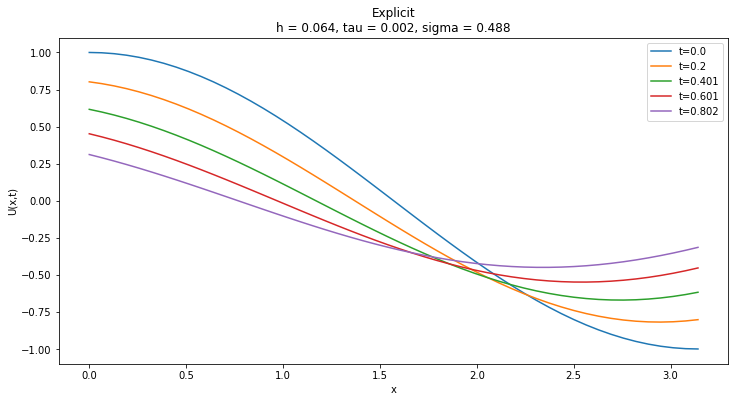

In [1191]:
depend_on_h(X1, Y1, Z1, "Explicit", explicit)

/tmp/ipykernel_6511/281241371.py:5: UserWarning: Sigma > 0.5
  warnings.warn("Sigma > 0.5")


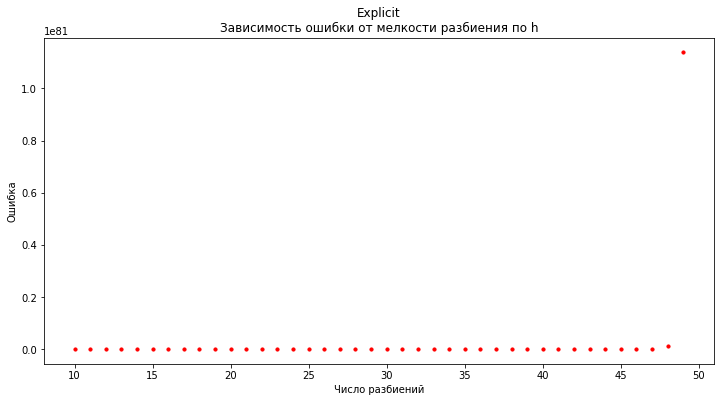

In [1192]:
error_on_h(explicit, U, "Explicit")


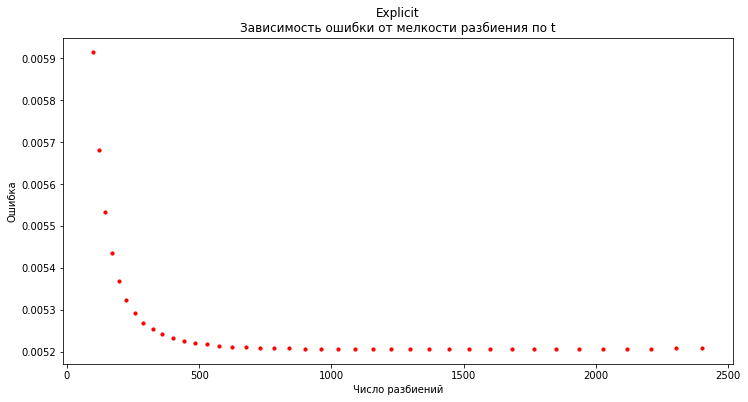

In [1193]:
error_on_t(explicit, U, "Explicit")

**Неявная схема**

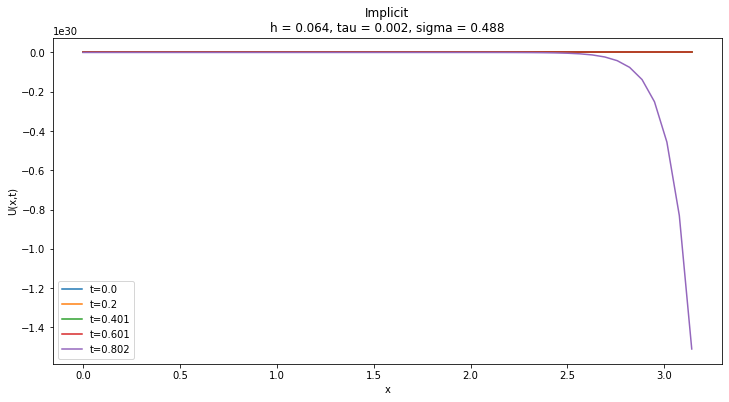

In [1194]:
depend_on_h(X2, Y2, Z2, "Implicit", implicit)

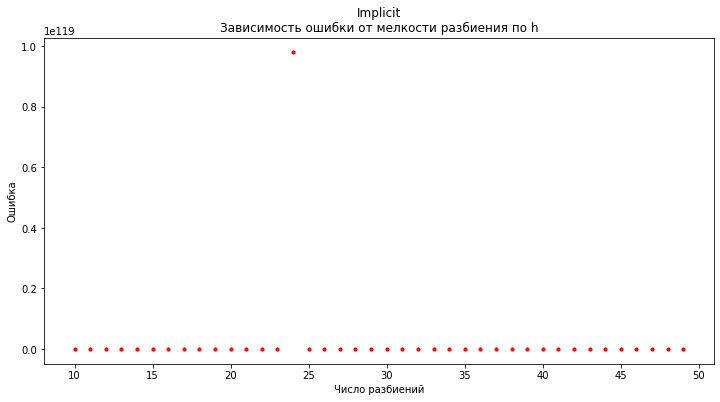

In [1195]:
error_on_h(implicit, U, "Implicit")


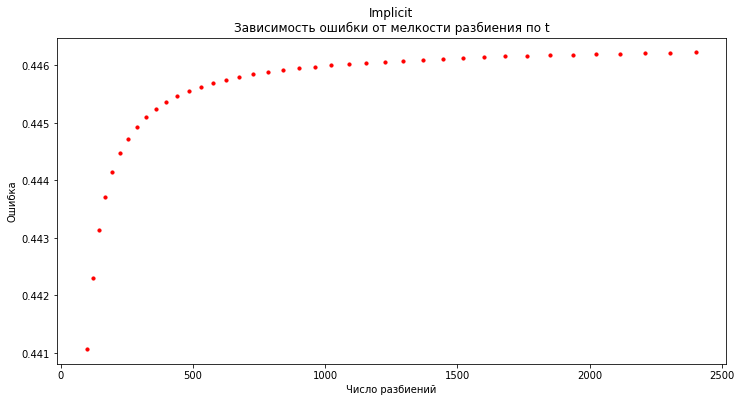

In [1196]:
error_on_t(implicit, U, "Implicit")

**Схема Кранка Николсона**

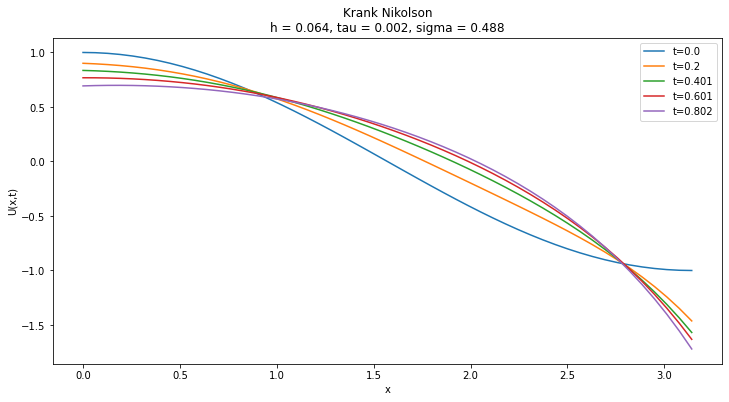

In [1197]:
depend_on_h(X3, Y3, Z3, "Krank Nikolson", exp_imp)

In [1198]:
print(exp_imp.theta)

0.5


/tmp/ipykernel_6511/7652003.py:5: RuntimeWarning: overflow encountered in double_scalars
  err += (Z[i][j] - U(X[j], Y[i])) ** 2


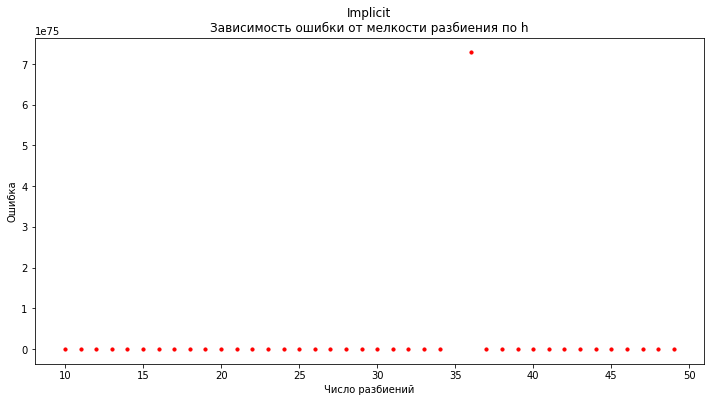

In [1199]:
error_on_h(exp_imp, U, "Implicit")